# Preprocessing Reads

In [3]:
# renaming reads
!seqtk rename $exp/zymo10_1000kto102k.fastq read_ | seqtk seq -A > $exp/reads.fasta

# obtaining read ids
!grep ">" $exp/reads.fasta > $exp/read_ids

SyntaxError: invalid syntax (3689357291.py, line 3)

# computing 4mers

In [4]:
!seq2vec -k 4 -o $exp/4mers -f $exp/reads.fasta -t 32

'seq2vec' is not recognized as an internal or external command,
operable program or batch file.


# Running KBM2

In [5]:
# Please use the alternative chunked method if you do not have enough memory
# Result will vary between the two methods slightly due to behavior of kbm2 and sampling 
!kbm2  -i $exp/reads.fasta -d $exp/reads.fasta -n 2000 -l 2560 -t 32 | python filter_alignments.py $exp/

'kbm2' is not recognized as an internal or external command,
operable program or batch file.


# Build Graph 

In [1]:
# reads path
exp = "../../../Results/zymo10_1000kto1100k/oblr/"

In [2]:
import os
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from  tqdm import tqdm
import seaborn as sns
import numpy as np
import pandas as pd

try:
    from cuml.manifold import UMAP
    from cuml.metrics.cluster.silhouette_score import cython_silhouette_score as silhouette_score
    from cuml.cluster import HDBSCAN
    print('Using CUML')
except Exception as e:
    from sklearn.metrics import silhouette_score
    from umap import UMAP
    from hdbscan import HDBSCAN
    print('Using SciPy', e)

Using SciPy No module named 'cuml'


### essential files from previous steps

* ground_truth.txt is optional and only needed for plots and visualization

In [3]:
alignments_file_path = exp + "reads.alns"
degrees_file_path = exp + "degree"

comp = pd.read_csv(exp + "4mers", delimiter=',', header=None).to_numpy()

try:
    truth = np.array(open(exp + "ground_truth.txt").read().strip().split("\n"))
except:
    truth = np.array([str(0) for x in range(len(comp))])
reads = exp + "reads.fasta"

### functions used

In [21]:
def get_palette(labels):
    palette = {x: f'C{n}' for n, x in enumerate(sorted(set(labels) - {-1, '-1', 'Unknown', 'unknown'}))}
    palette['Unknown'] = 'white'
    palette['-1'] = 'white'
    palette[-1] = 'white'
    
    return palette


def get_idx_maps(read_ids_file_path, truth):
    reads_truth = {}
    read_id_idx = {}
    
    with open(read_ids_file_path) as read_ids_file:
        for t, rid in tqdm(zip(truth, read_ids_file)):
            rid = rid.split(" ")[0].strip()[1:]  #modified: rid = rid.strip()[1:] 
            reads_truth[rid] = t
            read_id_idx[rid] = len(read_id_idx)
    return reads_truth, read_id_idx


def load_read_degrees(degrees_file_path):
    degree_array = np.zeros_like(truth, dtype=int)

    for line in tqdm(open(degrees_file_path, 'r')):
        i, d = line.strip().split()
        d = int(d)
        if (read_id_idx[i] == 1):
            
            print(read_id_idx[i], d)
        degree_array[read_id_idx[i]] = d
        
    return degree_array


def alignments_to_edges(alignments_file_path, edges_txt_path, read_id_idx, reads_truth):
    TP = 0
    FP = 0

    if not os.path.isfile(edges_txt_path):
        with open(edges_txt_path, "w+") as ef:
            for line in tqdm(open(alignments_file_path, "r")):
                u, v = line.strip().split('\t')

                if u == v:
                    continue

                ef.write(f"{read_id_idx[u]}\t{read_id_idx[v]}\n")

                if reads_truth[u] == 'Unknown' or reads_truth[v] == 'Unknown':
                    continue
                if reads_truth[u] == reads_truth[v]:  # HOW?
                    TP += 1
                else:
                    FP += 1
    return TP, FP


def load_edges_as_numpy(edges_txt_path, edges_npy_path):
    if not os.path.isfile(edges_npy_path):
        edges_txt = [x.strip() for x in tqdm(open(edges_txt_path))]
        edges = np.zeros((len(edges_txt), 2), dtype=np.int32)

        for i in tqdm(range(len(edges_txt))):
            e1, e2 = edges_txt[i].strip().split()
            edges[i]  = [int(e1), int(e2)]

        np.save(edges_npy_path, edges)
        
    return np.load(edges_npy_path)


def plot_degree_hist(degree, path=None):
    plt.figure(figsize=(10, 6))
    plt.rcParams.update({'font.size': 16})
    
    sns.histplot(degree_array[degree_array>1], binwidth=5) # it must be more than 1 (can have self edges)
    plt.ylabel('No. of Vertices', fontsize=18)
    plt.xlabel('Degree', fontsize=18)
    
    if path is not None:
        plt.savefig(path, dpi=1200, bbox_inches = 'tight')
    else:
        plt.show()
    

def plot_umap(embedding, labels, palette=None, path=None, paper=False):
    plt.figure(figsize=(10,10))
    plt.rcParams.update({'font.size': 16})
    plt.ylabel('UMAP 2', fontsize=18)
    plt.xlabel('UMAP 1', fontsize=18)
    
    if path is not None and not paper:
        sns.scatterplot(x=embedding.T[0], y=embedding.T[1], hue=labels, linewidth=0, alpha=0.5, palette=palette)
        plt.legend(bbox_to_anchor=(1,1), loc="upper left")
        plt.savefig(path, dpi=1200, bbox_inches = 'tight')
    if path is not None and paper:
        sns.scatterplot(x=embedding.T[0], y=embedding.T[1], hue=labels, linewidth=0, alpha=0.5, palette=palette, legend=False)
        plt.savefig(path.replace('.pdf', '-paper.pdf'), dpi=1200, bbox_inches = 'tight')
    else:
        sns.scatterplot(x=embedding.T[0], y=embedding.T[1], hue=labels, linewidth=0, alpha=0.5, palette=palette)
        plt.legend(bbox_to_anchor=(1,1), loc="upper left")

        
def get_highest_scoring_clustering(data, size):
    best_score = -1
    best_clusters = None
    best_size = -1
    
    try:
        clusters = HDBSCAN(min_cluster_size=size).fit_predict(data) #array with the cluster no of each data point --> [1 0 2 ... 2 1]
        print(clusters)
        if len(set(clusters) - {1}) == 0:
            return None, -1, None
        score = silhouette_score(data[clusters!=-1], clusters[clusters!=-1])

        print(size, score)
    except:
        pass

    if score > best_score:
        best_score = score
        best_clusters = clusters
        best_size = size
    
    return best_size, best_score, best_clusters


def get_best_embedding(data, weights):
    best_size = None
    best_sample_size = None
    best_sample_idx = None
    best_score = -1
    best_clusters = None
    best_embedding = None
    best_cluster_count = None
    
    for sample_size in [5000, 10000, 15000]:   #modified --> for sample_size in [25000, 50000, 100000]:
        print(f'Scanning sample size {sample_size}')
        sample_idx = np.random.choice(range(len(data)), size=sample_size, replace=False, p=weights/weights.sum()) #select 5000 ids
        sampled_data = data[sample_idx] #get the values of those selected ids from data nparray
        embedding = UMAP().fit_transform(sampled_data) # dimensionality reduction to 2 dims --> shape = (5000, )
        #modified --> size, score, clusters = get_highest_scoring_clustering(embedding, 500)
        size, score, clusters = get_highest_scoring_clustering(embedding, 300)
        count = len(set(clusters) - {-1})
        
        print(f'Cluster size = {size:5} Clusters = {count:5} Score = {score:1.5f}')
        
        if score > best_score:
            best_cluster_count = count
            best_size = size
            best_sample_size = sample_size
            best_score = score
            best_clusters = clusters
            best_embedding = embedding
            best_sample_idx = sample_idx
            
    return best_size, best_sample_size, best_score, best_clusters, best_cluster_count, best_embedding, best_sample_idx


def rename_clusters(clusters):
    rename_map = {k:n for n, k in enumerate(set(clusters) - {-1})}
    rename_map[-1] = -1

    clusters = np.array([rename_map[x] for x in clusters])
    
    return clusters

### preparing palettes for plotting and maps for read_id index matching

### computing feature scales and probabilities

100000it [00:01, 76817.11it/s]
17408it [00:00, 410777.36it/s]


Precision of reads (if ground truth provided) 0.0


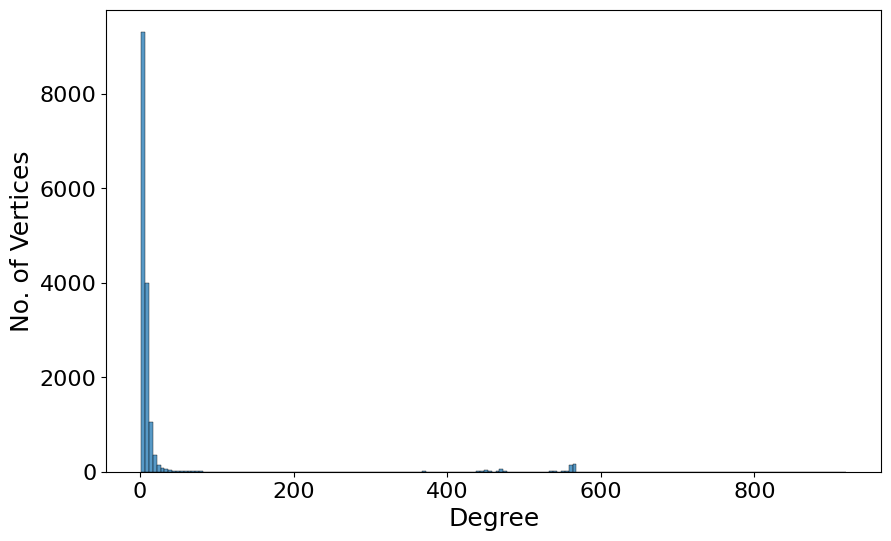

In [17]:
palette = get_palette(truth)
reads_truth, read_id_idx = get_idx_maps(exp + 'read_ids', truth)
degree_array = load_read_degrees(degrees_file_path)
TP, FP = alignments_to_edges(alignments_file_path, exp + "edges.txt", read_id_idx, reads_truth)

print("Precision of reads (if ground truth provided)", 100 * TP/ (TP+FP + 1e-5))

edges = load_edges_as_numpy(exp + "edges.txt", exp + "edges.npy")
sample_weights = np.zeros_like(degree_array, dtype=np.float32)
sample_scale = np.ones_like(degree_array, dtype=np.float32)

plot_degree_hist(degree_array)

In [22]:
print(degree_array)
for n, d in enumerate(degree_array):
    sample_weights[n] = 1.0/d if d>0 else 0
    sample_scale[n] = max(1, np.log10(max(1, d)))

scaled = comp * sample_scale.reshape(-1, 1)  # BROADCASTING


[ 0  0 11 ...  4  9  8]


### searching for the best clustering

In [23]:
results = []

for i in range(5):
    t_size, t_sample_size, t_score, t_clusters, t_cluster_count, t_embedding, t_sample_idx = get_best_embedding(scaled, sample_weights)
    
    results.append([t_size, t_sample_size, t_score, t_clusters, t_cluster_count, t_embedding, t_sample_idx])

Scanning sample size 5000
[1 1 1 ... 1 1 1]
300 0.6657583
Cluster size =   300 Clusters =     2 Score = 0.66576
Scanning sample size 10000
[4 2 0 ... 3 3 2]
300 0.6670907
Cluster size =   300 Clusters =     5 Score = 0.66709
Scanning sample size 15000
[4 1 4 ... 1 1 3]
300 0.6081986
Cluster size =   300 Clusters =     5 Score = 0.60820
Scanning sample size 5000
[2 1 1 ... 0 1 1]
300 0.6609074
Cluster size =   300 Clusters =     3 Score = 0.66091
Scanning sample size 10000
[ 2  2  2 ...  2 -1  1]
300 0.6599392
Cluster size =   300 Clusters =     5 Score = 0.65994
Scanning sample size 15000
[0 0 1 ... 1 4 1]
300 0.6142943
Cluster size =   300 Clusters =     5 Score = 0.61429
Scanning sample size 5000
[3 3 3 ... 2 2 3]
300 0.7347156
Cluster size =   300 Clusters =     4 Score = 0.73472
Scanning sample size 10000
[1 1 1 ... 1 0 1]
300 0.64187527
Cluster size =   300 Clusters =     2 Score = 0.64188
Scanning sample size 15000
[ 4  4  2 ...  2  2 -1]
300 0.66012585
Cluster size =   300 Clust

### chosing the best clustering result

In [24]:
size, sample_size, score, clusters, cluster_count, embedding, sample_idx = None, None, -1, None, 0, None, None

cluster_counts = Counter([result[4] for result in results])
cluster_counts = sorted(cluster_counts.most_common(), key=lambda x: (x[1], x[0]), reverse=True)
chose = cluster_counts[0][0]

print(f"Count stats = {cluster_counts}")
print(f'Maximally occuring cluster count = {chose}')

for result in results:
    if result[4] == chose and result[2] > score:
        size, sample_size, score, clusters, cluster_count, embedding, sample_idx = result

Count stats = [(5, 3), (4, 1), (3, 1)]
Maximally occuring cluster count = 5


In [25]:
print(f'Chosen Score = {score:3.4f} Sample_size = {sample_size:5} Size = {size} Clusters = {cluster_count}')

Chosen Score = 0.6948 Sample_size = 10000 Size = 300 Clusters = 5


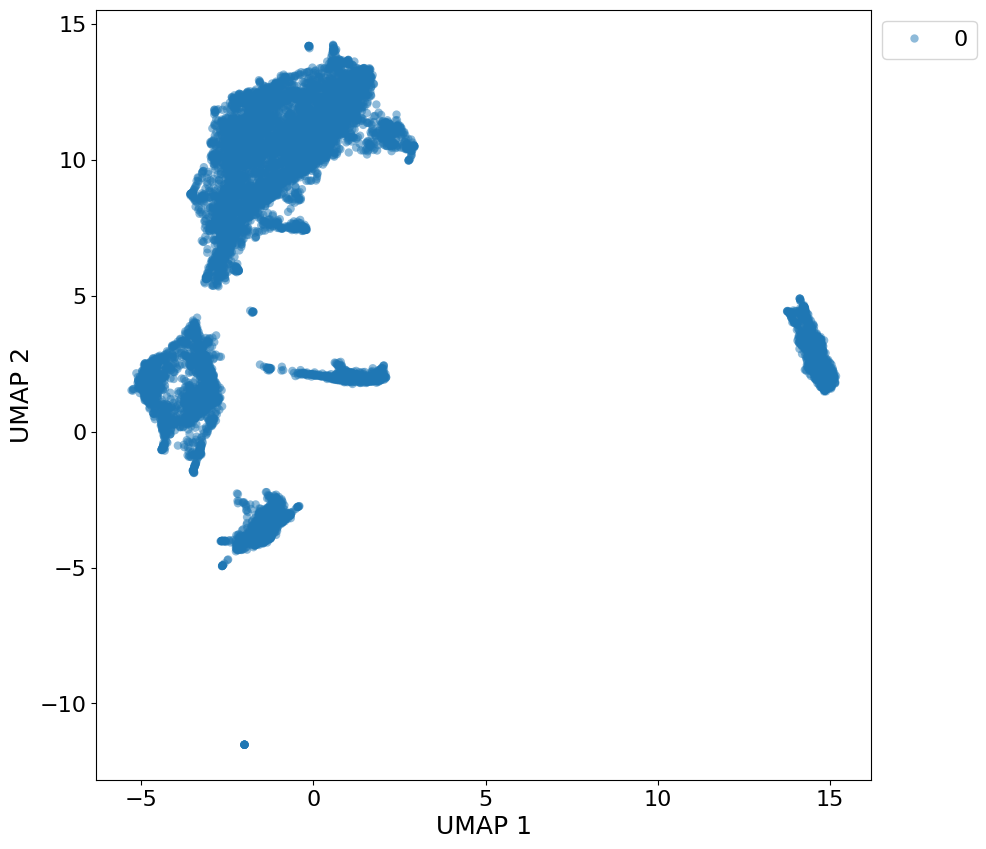

In [26]:
plot_umap(embedding, truth[sample_idx], palette)

In [27]:
clusters = rename_clusters(clusters)

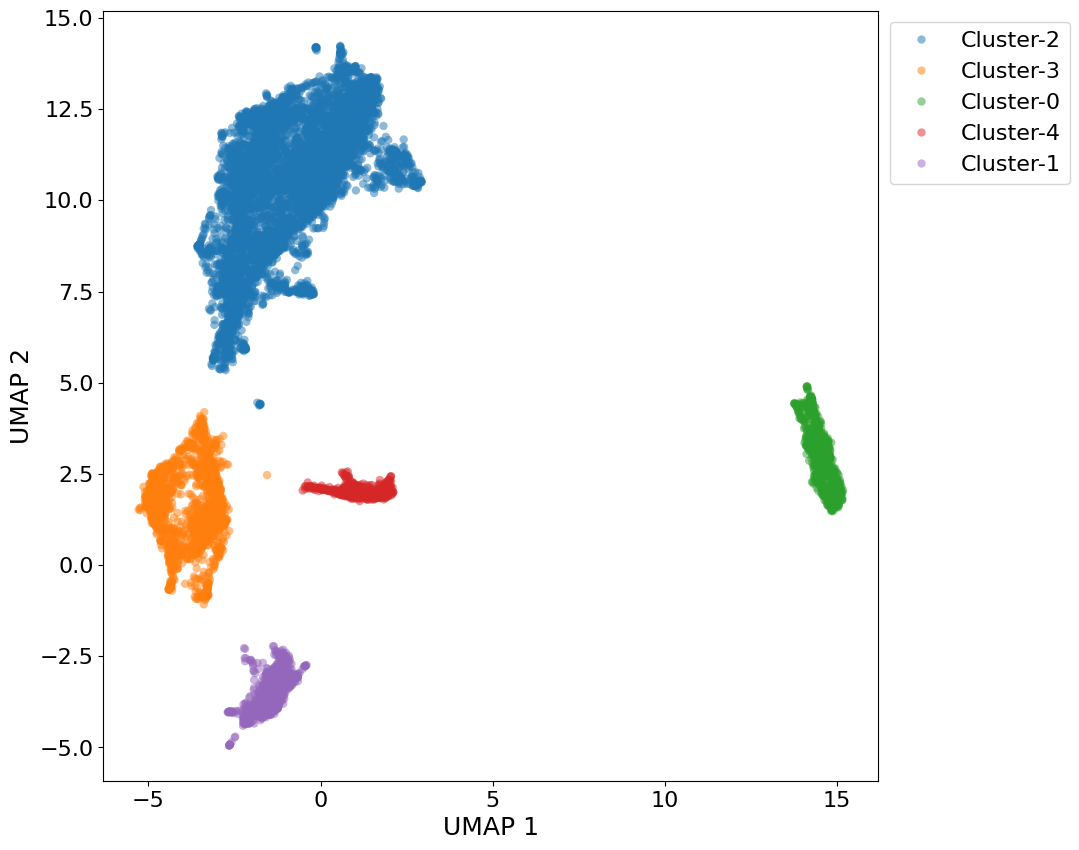

In [28]:
plot_umap(embedding[clusters!=-1], [f"Cluster-{x}" for x in clusters[clusters!=-1]])

In [29]:
read_cluster = np.array([[r, c] for r, c in zip(sample_idx, clusters) if c!=-1])

### carried forward data to the next step

In [30]:
np.savez(exp + 'data.npz', edges=edges, scaled=scaled, read_cluster=read_cluster)